# Time Series Forecasting using Recurrent Neural Network
- This tutorial covers developing RNN model to predict forecasts for a time series data. All model development has been done under `Tensorflow` framework.
-  Monthly anti-diabetic drug sales : [a10](https://rdrr.io/cran/fpp/man/a10.html) dataset from the `fpp` package in R language has been taken for model development.
- While building RNN models, different combinations (single vs multiple layers of RNN, Adam vs SGD optimizer) of RNN have been built in this notebook were tried.

In [1]:
# importing libraries necessary for data transformation, data pre-processing, model development etc

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib.legend import Legend
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

### 1. Data import and exploratory analysis

In [2]:
# importing the model development data
df = pd.read_csv('/content/a10.csv')

In [3]:
print(df.head())
print(df.tail())
print(df.shape)

         Date     Sales
0  1991-07-01  3.526591
1  1991-08-01  3.180891
2  1991-09-01  3.252221
3  1991-10-01  3.611003
4  1991-11-01  3.565869
           Date      Sales
199  2008-02-01  21.654285
200  2008-03-01  18.264945
201  2008-04-01  23.107677
202  2008-05-01  22.912510
203  2008-06-01  19.431740
(204, 2)


In [4]:
df1 = df.copy()

In [5]:
# converting index into sales dates : this will later help in plotting sales with right time

sales = df1
sales.index = pd.to_datetime(df1.Date)
sales = sales.drop(['Date'], axis=1)

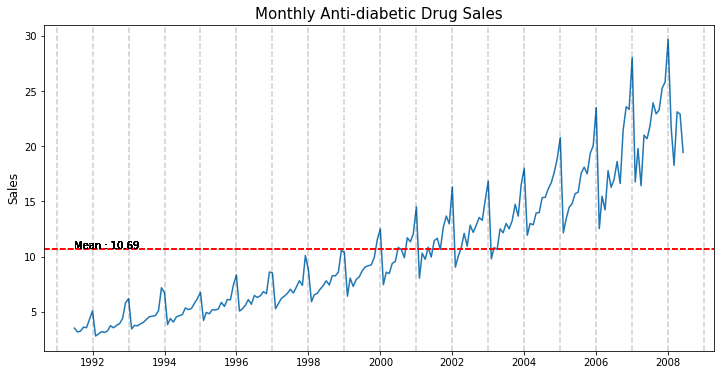

In [6]:
plt.figure(figsize=(12,6))
plt.plot(sales)
plt.title('Monthly Anti-diabetic Drug Sales', fontsize=15)
plt.ylabel('Sales', fontsize=12)

for year in range(sales.index[0].year, sales.index[-1].year+2):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)
    plt.axhline(sales.mean().Sales, color='r', alpha=0.2, linestyle='--')
    plt.text(sales.index[0], (sales.mean().Sales)+0.01, 'Mean : {}'.format(round((sales.mean().Sales),2)))

plt.show()

### 2. Pre-processing and Utility functions

In [7]:
# split model development data into train and test dataset
train_df = sales.iloc[:192]
test_df = sales.iloc[-12:]

In [8]:
# scale the train and test data in 0-1 range using MinMaxScaler

scaler_transformer = MinMaxScaler()
scaler_transformer.fit(train_df)
train_df_scaled = scaler_transformer.transform(train_df)
test_df_scaled = scaler_transformer.transform(test_df)
train_df_scaled.shape, test_df_scaled.shape

((192, 1), (12, 1))

In [9]:
# define training_window_data : input = 12 months of data and output = 1 month of data.
# this window slides forward by 1 month at a time, thus covering all months

output_features = 1
training_window_length = 12
training_window_data = TimeseriesGenerator(train_df_scaled, train_df_scaled,
                                           length=training_window_length, batch_size=1)
y_ip, y_op = training_window_data[0]
print('Input (t1 to t12) : {}'.format(np.round((y_ip.flatten()),3)))
print('Input shape (N Rows, Window Length, Output Features) : {}'.format(y_ip.shape))
print('Output (t13) : {}'.format(np.round(y_op,3)))
print('Output shape (N Rows, Output Features) : {}'.format(y_op.shape))

Input (t1 to t12) : [0.028 0.015 0.017 0.032 0.03  0.059 0.09  0.    0.007 0.015 0.012 0.018]
Input shape (N Rows, Window Length, Output Features) : (1, 12, 1)
Output (t13) : [[0.037]]
Output shape (N Rows, Output Features) : (1, 1)


In [10]:
# function to plot model loss per epoch

def model_loss_plot(history_log, title):
    plt.plot(history_log.history['loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [11]:
# function to plot model loss per epoch
# this function takes 1 window of data : 12 months of data, and makes a prediction for the next month
# the window is updated by sliding forward by 1 month. The new month data appended is true data and predicted data

def model_forecast(model):
    forecast = []
    
    test_window_data = train_df_scaled[-training_window_length:]
    test_window_data = test_window_data.reshape((1, training_window_length, output_features))
      
    for i in range(len(test_df)):
        # calcuate forecast for 1st window data
        prediction_i = model.predict(test_window_data)[0]
        forecast.append(prediction_i)
        
        # update the sliding window
        test_window_data = np.append(test_window_data[:,1:,:],[[test_df_scaled[i]]],axis=1)
        
    forecast_rescaled = scaler_transformer.inverse_transform(forecast)
    test_df['Forecast'] = forecast_rescaled
    test_error = np.round((mean_absolute_error(test_df['Sales'], test_df['Forecast'])),2)
    print(test_df)
    print('MAE : {}'.format(test_error))
    
    fig, axs = plt.subplots(figsize=(15, 5))
    
    axs.plot(train_df.Sales, label='Train Data Sales', color = 'red')
    axs.plot(test_df.Sales, label='Test Data Sales', color = 'green')
    axs.plot(test_df.Forecast, label = 'Forecasted Sales', color = 'orange')
    axs.plot(train_df.index[0], 0, label = 'Test MAE: {}'.format(test_error), color = 'white')
    for year in range(sales.index[0].year, sales.index[203].year+2):
        axs.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)
        axs.axvspan(sales.index[193], sales.index[203], facecolor='lightblue', alpha=0.2)
        axs.legend()
    plt.show()    

### 3. Model Development

#### 3.1 Basic RNN with Adam Optimizer

In [12]:
#clear states
tf.keras.backend.clear_session()
np.random.seed(21)

In [13]:
# define model architecture and parameters

model = tf.keras.models.Sequential([tf.keras.layers.SimpleRNN(256, activation='relu',
                                                              input_shape=[training_window_length,
                                                                           output_features]),
                                                              tf.keras.layers.Dense(1)])

model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit the model

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
rnn_basic_history = model.fit(training_window_data, epochs=80, callbacks=[lr_schedule])

Epoch 1/80
180/180 [==============================] - 6s 11ms/step - loss: 0.0719 - mae: 0.3156 - lr: 1.0000e-08
Epoch 2/80
180/180 [==============================] - 2s 11ms/step - loss: 0.0718 - mae: 0.3156 - lr: 1.1220e-08
Epoch 3/80
180/180 [==============================] - 2s 11ms/step - loss: 0.0718 - mae: 0.3155 - lr: 1.2589e-08
Epoch 4/80
180/180 [==============================] - 2s 12ms/step - loss: 0.0718 - mae: 0.3154 - lr: 1.4125e-08
Epoch 5/80
180/180 [==============================] - 2s 11ms/step - loss: 0.0717 - mae: 0.3153 - lr: 1.5849e-08
Epoch 6/80
180/180 [==============================] - 2s 12ms/step - loss: 0.0717 - mae: 0.3152 - lr: 1.7783e-08
Epoch 7/80
180/180 [==============================] - 2s 12ms/step - loss: 0.0717 - mae: 0.3151 - lr: 1.9953e-08
Epoch 8/80
180/180 [==============================] - 2s 12ms/step - loss: 0.0716 - mae: 0.3150 - lr: 2.2387e-08
Epoch 9/80
180/180 [==============================] - 2s 12ms/step - loss: 0.0716 - mae: 0.3149 

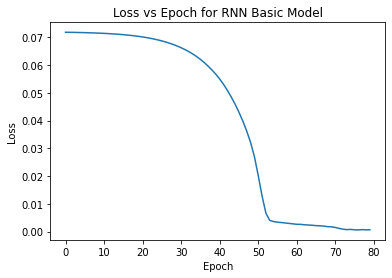

In [15]:
# model performance on train data
model_loss_plot(rnn_basic_history, 'Loss vs Epoch for RNN Basic Model')

                Sales   Forecast
Date                            
2007-07-01  21.834890  18.948380
2007-08-01  23.930204  20.659173
2007-09-01  22.930357  20.498823
2007-10-01  23.263340  23.226674
2007-11-01  25.250030  24.478170
2007-12-01  25.806090  25.141887
2008-01-01  29.665356  27.563219
2008-02-01  21.654285  19.932127
2008-03-01  18.264945  22.140232
2008-04-01  23.107677  18.449293
2008-05-01  22.912510  21.587806
2008-06-01  19.431740  22.173881
MAE : 2.21


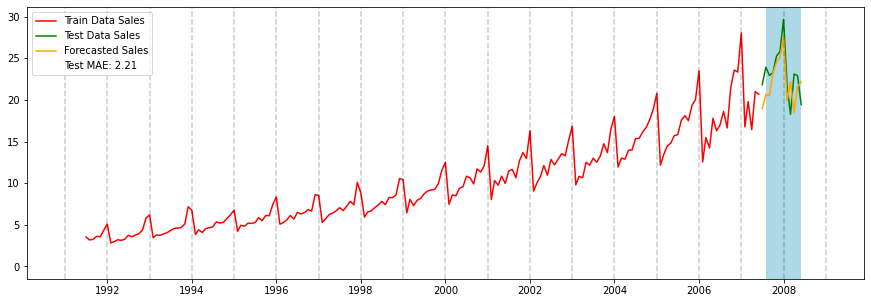

In [16]:
# model forecasts and performance on test data
model_forecast(model)

#### 3.2 Basic RNN with SGD Optimizer

In [17]:
#clear staes
tf.keras.backend.clear_session()
np.random.seed(21)

In [18]:
# define model architecture and parameters

model = tf.keras.models.Sequential([tf.keras.layers.SimpleRNN(256, activation='relu',
                                                              input_shape=[training_window_length,
                                                                           output_features]),
                                                              tf.keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fit the model

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
rnn_basic_history = model.fit(training_window_data, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
180/180 [==============================] - 2s 5ms/step - loss: 0.0688 - mae: 0.3087 - lr: 1.0000e-08
Epoch 2/100
180/180 [==============================] - 1s 5ms/step - loss: 0.0688 - mae: 0.3087 - lr: 1.1220e-08
Epoch 3/100
180/180 [==============================] - 1s 5ms/step - loss: 0.0688 - mae: 0.3087 - lr: 1.2589e-08
Epoch 4/100
180/180 [==============================] - 1s 8ms/step - loss: 0.0688 - mae: 0.3087 - lr: 1.4125e-08
Epoch 5/100
180/180 [==============================] - 2s 9ms/step - loss: 0.0688 - mae: 0.3087 - lr: 1.5849e-08
Epoch 6/100
180/180 [==============================] - 1s 8ms/step - loss: 0.0688 - mae: 0.3086 - lr: 1.7783e-08
Epoch 7/100
180/180 [==============================] - 1s 5ms/step - loss: 0.0688 - mae: 0.3086 - lr: 1.9953e-08
Epoch 8/100
180/180 [==============================] - 1s 7ms/step - loss: 0.0687 - mae: 0.3086 - lr: 2.2387e-08
Epoch 9/100
180/180 [==============================] - 1s 8ms/step - loss: 0.0687 - mae: 0.3085 

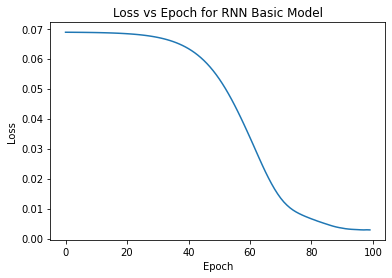

In [20]:
# model performance on train data
model_loss_plot(rnn_basic_history, 'Loss vs Epoch for RNN Basic Model')

                Sales   Forecast
Date                            
2007-07-01  21.834890  19.291897
2007-08-01  23.930204  19.932298
2007-09-01  22.930357  20.675569
2007-10-01  23.263340  21.144716
2007-11-01  25.250030  21.501603
2007-12-01  25.806090  22.114709
2008-01-01  29.665356  22.807122
2008-02-01  21.654285  24.116026
2008-03-01  18.264945  22.799807
2008-04-01  23.107677  20.734068
2008-05-01  22.912510  21.177898
2008-06-01  19.431740  21.201720
MAE : 3.17


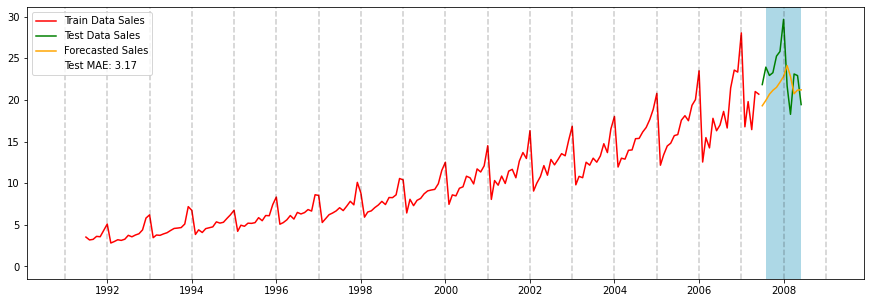

In [21]:
# model forecasts and performance on test data
model_forecast(model)

#### 3.3 RNN with 2 Layers and Adam optimizer

In [22]:
#clear states
tf.keras.backend.clear_session()
np.random.seed(21)

In [23]:
# define model architecture and parameters

model = tf.keras.models.Sequential([tf.keras.layers.SimpleRNN(256, activation='relu',
                                                              return_sequences=True,
                                                              input_shape=[training_window_length,
                                                                           output_features]),
                                                              tf.keras.layers.SimpleRNN(256),
                                                              tf.keras.layers.Dense(1)])

model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 12, 256)           66048     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               131328    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-trainable params: 0
_________________________________________________________________


In [24]:
# fit the model

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
rnn_2L_history = model.fit(training_window_data, epochs=75, callbacks=[lr_schedule])

Epoch 1/75
180/180 [==============================] - 4s 16ms/step - loss: 0.0663 - mae: 0.2995 - lr: 1.0000e-08
Epoch 2/75
180/180 [==============================] - 2s 13ms/step - loss: 0.0656 - mae: 0.2978 - lr: 1.1220e-08
Epoch 3/75
180/180 [==============================] - 2s 14ms/step - loss: 0.0649 - mae: 0.2959 - lr: 1.2589e-08
Epoch 4/75
180/180 [==============================] - 3s 16ms/step - loss: 0.0641 - mae: 0.2938 - lr: 1.4125e-08
Epoch 5/75
180/180 [==============================] - 3s 14ms/step - loss: 0.0631 - mae: 0.2914 - lr: 1.5849e-08
Epoch 6/75
180/180 [==============================] - 3s 16ms/step - loss: 0.0621 - mae: 0.2887 - lr: 1.7783e-08
Epoch 7/75
180/180 [==============================] - 2s 13ms/step - loss: 0.0610 - mae: 0.2858 - lr: 1.9953e-08
Epoch 8/75
180/180 [==============================] - 2s 10ms/step - loss: 0.0597 - mae: 0.2826 - lr: 2.2387e-08
Epoch 9/75
180/180 [==============================] - 3s 17ms/step - loss: 0.0583 - mae: 0.2789 

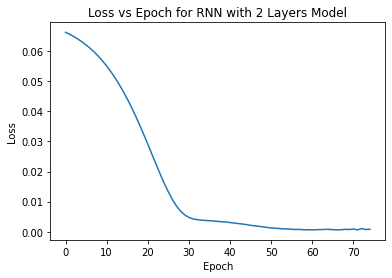

In [25]:
# model performance on train data
model_loss_plot(rnn_2L_history, 'Loss vs Epoch for RNN with 2 Layers Model')

                Sales   Forecast
Date                            
2007-07-01  21.834890  18.203064
2007-08-01  23.930204  19.653891
2007-09-01  22.930357  17.119494
2007-10-01  23.263340  22.700702
2007-11-01  25.250030  25.538801
2007-12-01  25.806090  25.487301
2008-01-01  29.665356  30.853241
2008-02-01  21.654285  19.050370
2008-03-01  18.264945  22.033195
2008-04-01  23.107677  18.231418
2008-05-01  22.912510  21.855938
2008-06-01  19.431740  22.696804
MAE : 2.64


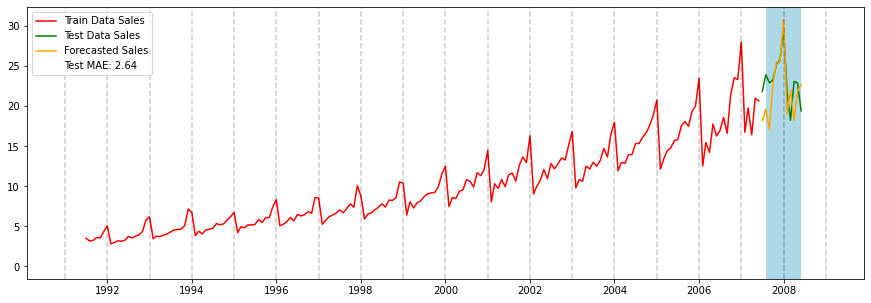

In [26]:
# model forecasts and performance on test data
model_forecast(model)

#### 3.4 RNN with 2 Layers and SGD optimizer

In [27]:
#clear states
tf.keras.backend.clear_session()
np.random.seed(21)

In [28]:
model = tf.keras.models.Sequential([tf.keras.layers.SimpleRNN(256, activation='relu',
                                                              return_sequences=True,
                                                              input_shape=[training_window_length,
                                                                           output_features]),
                                                              tf.keras.layers.SimpleRNN(256),
                                                              tf.keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 12, 256)           66048     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               131328    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-trainable params: 0
_________________________________________________________________


In [29]:
# fit the model

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
rnn_2L_history = model.fit(training_window_data, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
180/180 [==============================] - 3s 9ms/step - loss: 0.0334 - mae: 0.2075 - lr: 1.0000e-08
Epoch 2/100
180/180 [==============================] - 2s 9ms/step - loss: 0.0334 - mae: 0.2073 - lr: 1.1220e-08
Epoch 3/100
180/180 [==============================] - 2s 9ms/step - loss: 0.0333 - mae: 0.2071 - lr: 1.2589e-08
Epoch 4/100
180/180 [==============================] - 2s 9ms/step - loss: 0.0333 - mae: 0.2069 - lr: 1.4125e-08
Epoch 5/100
180/180 [==============================] - 2s 9ms/step - loss: 0.0332 - mae: 0.2066 - lr: 1.5849e-08
Epoch 6/100
180/180 [==============================] - 2s 9ms/step - loss: 0.0331 - mae: 0.2063 - lr: 1.7783e-08
Epoch 7/100
180/180 [==============================] - 2s 9ms/step - loss: 0.0330 - mae: 0.2060 - lr: 1.9953e-08
Epoch 8/100
180/180 [==============================] - 2s 9ms/step - loss: 0.0330 - mae: 0.2056 - lr: 2.2387e-08
Epoch 9/100
180/180 [==============================] - 2s 9ms/step - loss: 0.0328 - mae: 0.2051 

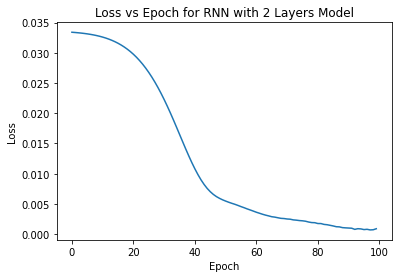

In [30]:
# model performance on train data
model_loss_plot(rnn_2L_history, 'Loss vs Epoch for RNN with 2 Layers Model')

                Sales   Forecast
Date                            
2007-07-01  21.834890  20.470496
2007-08-01  23.930204  20.740716
2007-09-01  22.930357  20.464141
2007-10-01  23.263340  24.389284
2007-11-01  25.250030  26.328145
2007-12-01  25.806090  27.125019
2008-01-01  29.665356  29.837904
2008-02-01  21.654285  22.194641
2008-03-01  18.264945  22.712592
2008-04-01  23.107677  19.738570
2008-05-01  22.912510  23.569012
2008-06-01  19.431740  23.214365
MAE : 1.96


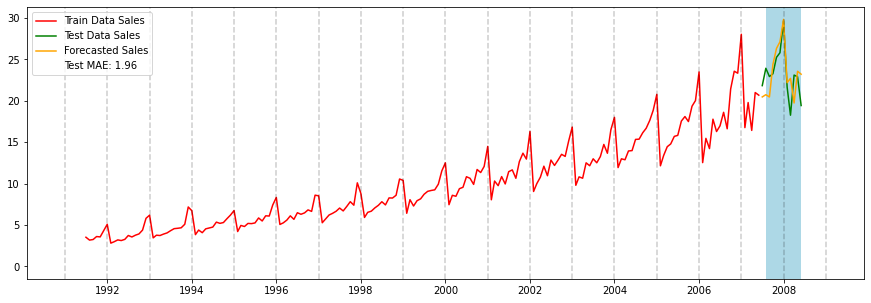

In [31]:
# model forecasts and performance on test data
model_forecast(model)